## Main workflow of PyTorch
1. Getting data ready
2. Building a model
   1. Model Class
   2. Loss Function
   3. Optimizer
   4. Training Loop
3. Fitting the model to data (training)
4. Making predictions and evaluating a model (testing)
5. Saving and loading a model
6. Putting it all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## 1. Data

In [2]:
# create custom data for linear regression
# create *known* parameters
weight = 0.7
bias = 0.3

# create data
start, end, step = 0, 1, 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data

- Training set: ~60-80%
- Validation set: ~10-20% (Optional)
- Testing set: ~10-20%

In [3]:
# create train test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

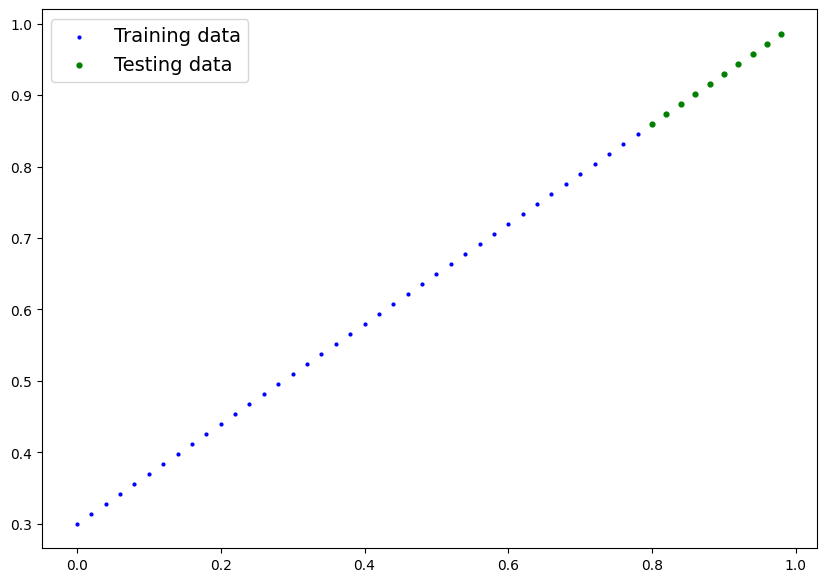

In [4]:
# Plots training data, test data and compares predictions.
# "visualize, visualize, visualize!"

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):  
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=12, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});
  
plot_predictions();

## 2. Build model

In [5]:
# create a linear regression model class

# almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(
                1, # start with random weights (this will get adjusted as the model learns)
                dtype=torch.float
            ),
            requires_grad=True # can we update this value with gradient descent?
        )
        self.bias = nn.Parameter(
            torch.randn(
                1, # start with random bias (this will get adjusted as the model learns)
                dtype=torch.float
            ),
            requires_grad=True # can we update this value with gradient descent?
        )
        
    # Forward defines the computation in the model
    # "x" is the input data (e.g. training/testing features)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # this is the linear regression formula (y = m*x + b)

**Note**:
- `nn.Module` contains the larger building blocks (layers)
- `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
- `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within `nn.Module`(s)
- `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data


### Checking the contents of a PyTorch model

In [6]:
# set seed so can be reprodue model
torch.manual_seed(42)

# create new object of model
model_0 = LinearRegressionModel()

# see model params
# list(model_0.parameters())
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions (inference mode)

Untuk mengecek `X_test` data dan memprediksi `y_test`, kita gunakan mode inference atau no_grad agar bobot pada parameters model tidak berubah karena backpropagation. (pembaruan bobot)

Jika kita memasukan data pada model, maka secara otomatis method `forward()` akan dijalankan dan mengembalikan nilai hasil prediksi.

In [7]:
# make predictions with model
# inference_mode lebih cepat dari no_grad
with torch.inference_mode():
    y_preds = model_0(X_test)

# older pytorch use torch.no_grad()
# tapi ini bisa juga sih buat skrng
# with torch.no_grad():
#     y_preds = model_0(X_test)

In [8]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


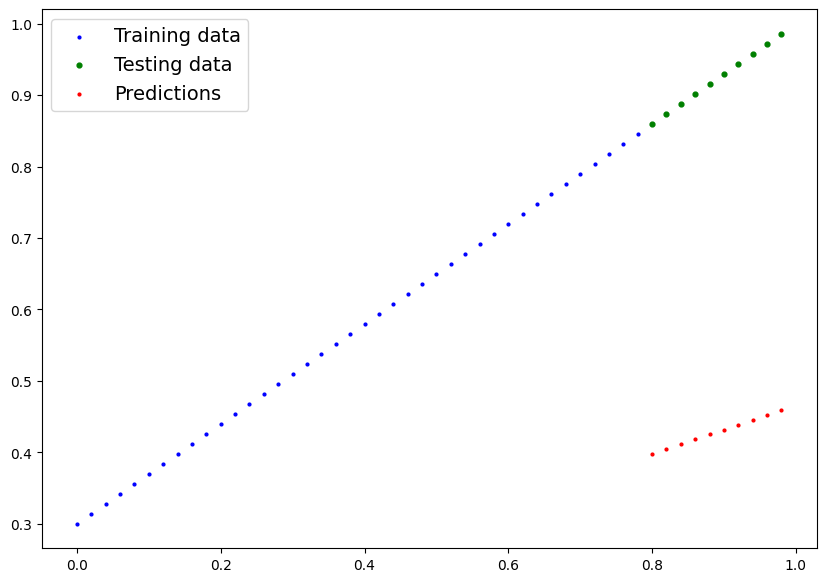

In [9]:
# plot predictions result
plot_predictions(predictions=y_preds)

Hasil prediksi sangat jelek. **:(**

Hal tersebut karena parameter yang digunakan masih random, belum ada training dan optimasi.

In [10]:
# cek error
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train model

### Creating a loss function and optimizer in PyTorch

- **Loss function**: Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better. Common values:
  - MAE fro regression
  - Binary cross enthropy for binary classification

<br>

- **Optimizer**: Tells your model how to update its internal parameters to best lower the loss. Common values:
  - Stochastic gradient descent (SGD)
  - Adam optimizer

In [11]:
# create loss function
loss_fn = nn.L1Loss() # MAE loss

# create optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(), # parameters of target model to optimize
    lr=0.01 # # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
)

### PyTorch training loop


| Number | Step name                                 | What does it do?                                               | Code example                    |
| ------ | ---------------------------------------- | -------------------------------------------------------------- | ------------------------------- |
| 1      | Forward pass                             | The model goes through all of the training data once, performing its forward() function calculations. | `model(x_train)`                |
| 2      | Calculate the loss                       | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3      | Zero gradients                           | The optimizer's gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()`         |
| 4      | Perform backpropagation on the loss      | Computes the gradient of the loss with respect to every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards". | `loss.backward()`               |
| 5      | Update the optimizer (gradient descent) | Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them. | `optimizer.step()`              |


**Note**:
Some rules of thumb:
- Calculate the loss (`loss = ...`) before performing backpropagation on it (`loss.backward()`).
- Zero gradients (`optimizer.zero_grad()`) before stepping them (`optimizer.step()`).
- Step the optimizer (`optimizer.step()`) after performing backpropagation on the loss (`loss.backward()`).


### PyTorch testing loop

| Number | Step name                                  | What does it do?                                               | Code example                            |
| ------ | ------------------------------------------ | -------------------------------------------------------------- | --------------------------------------- |
| 1      | Forward pass                              | The model goes through all of the training data once, performing its forward() function calculations. | `model(x_test)`                         |
| 2      | Calculate the loss                        | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)`        |
| 3      | Calculate evaluation metrics (optional)   | Alongside the loss value, you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions                        |


### Main training and testing loop

In [12]:
torch.manual_seed(420)

epochs = 100

# empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    
    # put model in training mode
    model_0.train()
    
    # 1. forward pass on train data
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss (predict, real value)
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Progress the optimizer
    optimizer.step()
    
    ### Testing
    
    # put model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. forward pass on test data
        test_pred = model_0(X_test)
        
        # 2. calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        
        # print out result
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


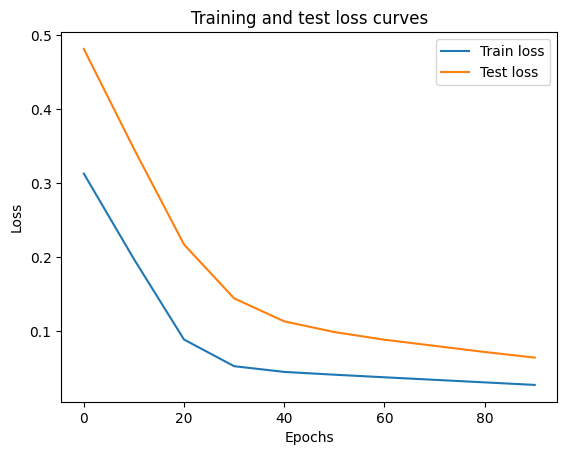

In [13]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Hasilnya lebih baik daripada menggunakan parameter awal. **Loss** semakin berkurang dari waktu ke waktu, menandakan `weights` dan `bias` berubah menjadi lebih baik.

In [14]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. Making predictions with a trained model (inference)

In [15]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

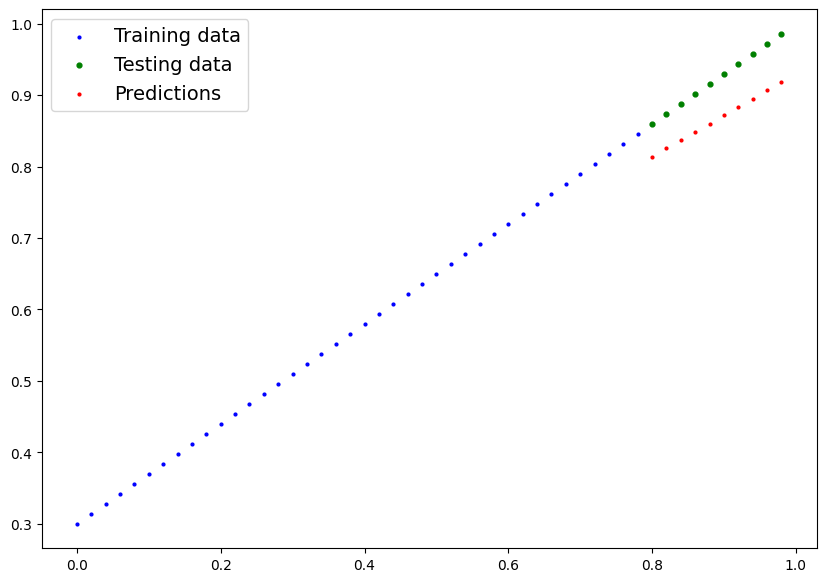

In [16]:
plot_predictions(predictions=y_preds)

## 5. Saving and loading PyTorch model

- `torch.save`: Saves a serialized object to disk using `pickle`.
- `torch.load`: Deserialize saved `pickle` object file.
- `torch.nn.Module.load_state_dict`: Load model params dictionarry (`model.state_dict()`)

**Note**: save as pickle module is not secure. Because we didnt know what inside in the pickle file object. Only use this on trusted source.

### Saving PyTorch model's `state_dict()`

In [17]:
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01-pytorch-workflow-model-0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01-pytorch-workflow-model-0.pth


In [18]:
# Check the saved file path
!ls -l models/

total 2624
-rw-r--r-- 1 sugab sugab 2681311 Agu 24 15:02 00-model.pth
-rw-r--r-- 1 sugab sugab    1207 Agu 25 13:06 01-pytorch-workflow-model-0.pth


**Note**: We only save the models parameters dictionary, not entire model object. When load the saved model, we must instantiate the model class first into object. After that, we load the parameters dictionary into the new model object.

Saving the entire model rather than just the state_dict() is more intuitive, however, to quote the PyTorch documentation:

> The disadvantage of this approach (saving the whole model) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
> 
> Because of this, your code can break in various ways when used in other projects or after refactors.


### Loading saved PyTorch model's `state_dict()`

In [19]:
# instantiate a new model object
loaded_model_0 = LinearRegressionModel()

# load state_dict of our saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [20]:
# test loaded model
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [21]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])